**XAI TME 1: Explication par génération d’exemples contre-factuels**<br>**Noms:** <br>Marilyn CHAHINE<br>Marina SANGINETO

In [224]:
import sklearn
from sklearn import svm
from collections.abc import Sequence
import numpy as np
from numpy.typing import NDArray
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier

**1. Données**

In [225]:
X, y = sklearn.datasets.make_moons(n_samples=1000, shuffle=True, noise=None, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

**2. Classifieurs**

In [226]:
clf = svm.SVC()
clf.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


**3. Génération d'exemples contrefactuels**
  <br> 3.1. Algorithm 3

In [227]:
def uniformGenSL(x, a0, a1, n):
    """
    x : array-like, shape (d,)
    a0, a1 : scalars with 0 <= a0 < a1
    n : number of points to generate
    returns: array shape (n, d)
    """
    x = np.asarray(x)
    d = x.shape[0]

    # 1) generate n standard normal vectors (center 0, covariance I_d)
    Y = np.random.randn(n, d)             # each row ~ N(0, I_d)

    # 2) normalize to unit vectors
    norms = np.linalg.norm(Y, axis=1, keepdims=True)
    # avoid division by zero (very unlikely)
    norms[norms == 0] = 1.0
    U = Y / norms                          # shape (n, d), unit directions
    # 3) sample radii so volume is uniform in layer
    # sample uniformly in [a0^d, a1^d]
    low = a0**d
    high = a1**d
    V = np.random.uniform(low, high, size=(n,))
    r = V**(1.0/d)                         # radii

    # 4) form points
    points = x + (r[:, None] * U)          # shape (n, d)
    return points


    3.2. Algorithm 1

In [228]:
def growingSpheresGen(clf, x, rad, n):
    a0 = 0
    a1 = rad
    Z = uniformGenSL(x, a0, a1, n)
    found = False
    
    while (found == False):
        for e in Z:
            if (clf.predict([e]) != clf.predict([x])):
                rad = rad/2
                Z = uniformGenSL(x, 0, rad, n)
            elif (np.array_equal(e, Z[-1])):
                found = True
            
    a0 = rad
    a1 = 2*rad

    found = False
    while (found == False):
        for e in Z:
            if (clf.predict([e]) != clf.predict([x])):
                e_final = e
                found = True
                break
            elif (np.array_equal(e, Z[-1])):
                Z = uniformGenSL(x, a0, a1, n)
                a0 = a1
                a1 = a1 + rad
                
    return e_final

    3.3. Algorithm 2

In [229]:
def growingSpheresFeatureSelec(clf, x, e):
    e_temp = e.copy()
    while ( clf.predict([e_temp]) != clf.predict([x])):
        e_opt = e_temp.copy()
        dist_list = []
        for j in range(len(x)):
            if (e_temp[j] == x[j]):
                dist_list.append(np.inf)
            else:
                dist_list.append(abs(e_temp[j] - x[j]))
        i = np.argmin(dist_list)
        e_temp[i] = x[i]
    return e_opt

   3.4. Tester l'algorithme

In [230]:
print("Data point we're studying: ", X_test[0])
e = growingSpheresGen(clf, X_test[0], 0.1, 10)
e_opt = growingSpheresFeatureSelec(clf, X_test[0], e)
print("Counterfactual point we got: ", e_opt)

Data point we're studying:  [ 0.49818367 -0.3649742 ]
Counterfactual point we got:  [ 0.81634409 -0.12548588]


**4. Visualisation**

In [231]:
def plotResults_2Features_SVM(X_train, y_train, clf, x, y, e):
    X_feature1 = []
    X_feature2 = []
    
    for elem in X_train:
        X_feature1.append(elem[0])
        X_feature2.append(elem[1])
    
    colors = np.where(np.asarray(y_train) == 1, "red", "blue")
    
    plt.figure(figsize=(6, 5))
    
    
    # Données
    plt.scatter(X_feature1, X_feature2, c=colors, s=1, edgecolor="none")
    
    
    # Frontiere de décision
       # 1. Create a grid of points
    xx, yy = np.meshgrid(
        np.linspace(X_train[:,0].min()-1, X_train[:,0].max()+1, 200),
        np.linspace(X_train[:,1].min()-1, X_train[:,1].max()+1, 200)
    )
    
       # 2. Evaluate decision function
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
       # 3. Plot decision boundary (level set where Z = 0)
    plt.contour(xx, yy, Z, levels=[0], linewidths=0.5, colors="k")
    plt.contourf(xx, yy, Z, levels=[-np.inf,0,np.inf], colors=["blue","red"], alpha=0.2)
    
    
    # Donnée à expliquer
    if y == 0:
        plt.scatter(x[0], x[1], c="blue", s=2, edgecolors="k")
    elif y == 1:
        plt.scatter(x[0], x[1], c="red", s=2, edgecolors="k")


    # Exemple contrefactuel
    plt.scatter(e[0], e[1], c="green", s=20, edgecolors="none")
    
    
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Scatter Plot with: \n X = Feature 1, Y = Feature 2, Red/Blue = class1/class2, \n separating line = SVM decision border, circled point is the data point \n to be explained by a counterfactual example, and green point is the counterfactual")
    plt.show()

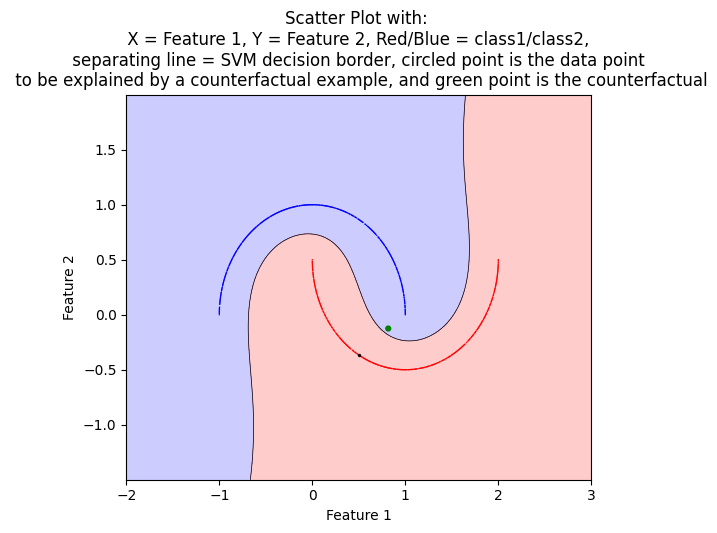

In [232]:
plotResults_2Features_SVM(X_train, y_train, clf, X_test[0], y_test[0], e_opt)

**5. Expérimentations sur données artificielles**

**Ajout de bruit**

In [233]:
# Ajout de bruit

X_noise1, y_noise1 = sklearn.datasets.make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=42)
X_noise2, y_noise2 = sklearn.datasets.make_moons(n_samples=1000, shuffle=True, noise=0.4, random_state=42)
X_noise3, y_noise3 = sklearn.datasets.make_moons(n_samples=1000, shuffle=True, noise=0.6, random_state=42)

X_train_noise1, X_test_noise1, y_train_noise1, y_test_noise1 = train_test_split(X_noise1, y_noise1, test_size=0.1, random_state=42)
X_train_noise2, X_test_noise2, y_train_noise2, y_test_noise2 = train_test_split(X_noise2, y_noise2, test_size=0.1, random_state=42)
X_train_noise3, X_test_noise3, y_train_noise3, y_test_noise3 = train_test_split(X_noise3, y_noise3, test_size=0.1, random_state=42)

clf_noise1 = svm.SVC()
clf_noise1.fit(X_train_noise1, y_train_noise1)

clf_noise2 = svm.SVC()
clf_noise2.fit(X_train_noise2, y_train_noise2)

clf_noise3 = svm.SVC()
clf_noise3.fit(X_train_noise3, y_train_noise3)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


**Noise level 1**

Data point we're studying:  [ 0.62477602 -0.45488941]
Counterfactual point we got:  [ 0.91865077 -0.02874656]


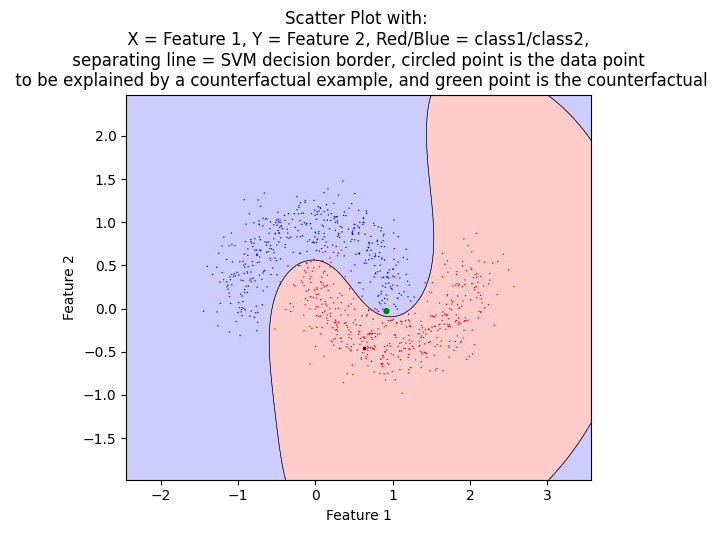

In [234]:
print("Data point we're studying: ", X_test_noise1[0])
e_noise1 = growingSpheresGen(clf_noise1, X_test_noise1[0], 0.1, 10)
e_opt_noise1 = growingSpheresFeatureSelec(clf_noise1, X_test_noise1[0], e_noise1)
print("Counterfactual point we got: ", e_opt_noise1)
plotResults_2Features_SVM(X_train_noise1, y_train_noise1, clf_noise1, X_test_noise1[0], y_test_noise1[0], e_opt_noise1)

**Noise level 2**

Data point we're studying:  [ 0.75136837 -0.54480462]
Counterfactual point we got:  [0.75136837 0.40341042]


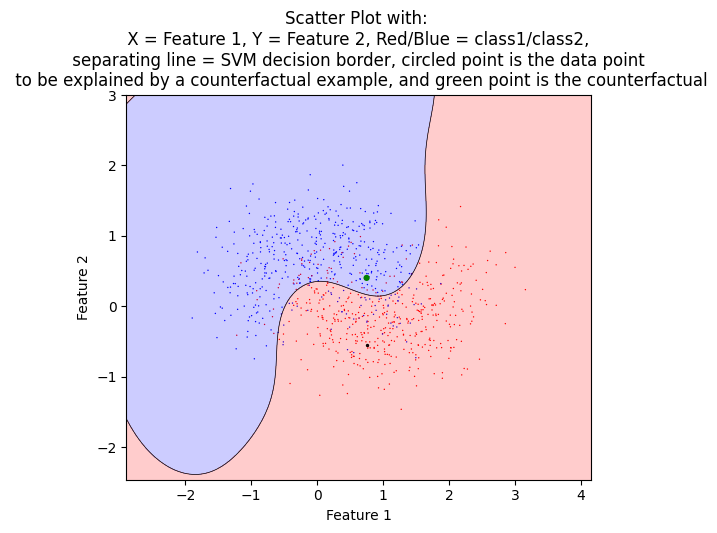

In [235]:
print("Data point we're studying: ", X_test_noise2[0])
e_noise2 = growingSpheresGen(clf_noise2, X_test_noise2[0], 0.1, 10)
e_opt_noise2 = growingSpheresFeatureSelec(clf_noise2, X_test_noise2[0], e_noise2)
print("Counterfactual point we got: ", e_opt_noise2)
plotResults_2Features_SVM(X_train_noise2, y_train_noise2, clf_noise2, X_test_noise2[0], y_test_noise2[0], e_opt_noise2)

**Noise level 3**

Data point we're studying:  [ 0.87796072 -0.63471982]
Counterfactual point we got:  [0.87796072 0.55985724]


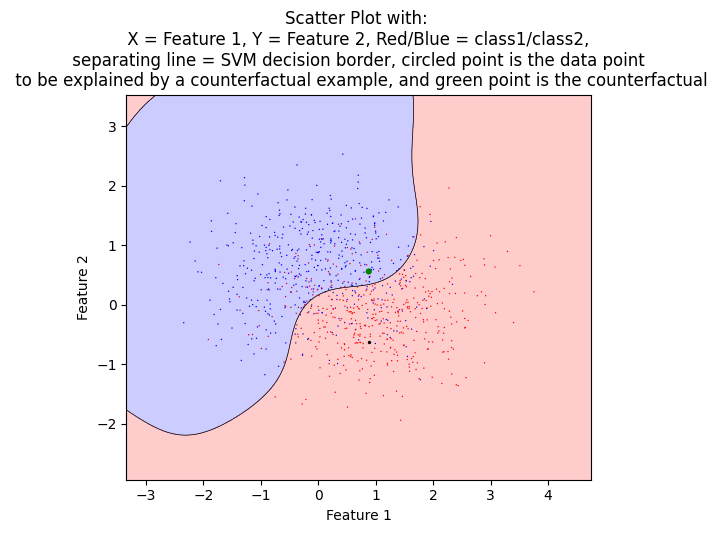

In [236]:
print("Data point we're studying: ", X_test_noise3[0])
e_noise3 = growingSpheresGen(clf_noise3, X_test_noise3[0], 0.1, 10)
e_opt_noise3 = growingSpheresFeatureSelec(clf_noise3, X_test_noise3[0], e_noise3)
print("Counterfactual point we got: ", e_opt_noise3)
plotResults_2Features_SVM(X_train_noise3, y_train_noise3, clf_noise3, X_test_noise3[0], y_test_noise3[0], e_opt_noise3)

**Interpretation:**
<br>Plus on ajoute du bruit, plus les points se superposent et donc plus on aura des points d'une classe qui seront prédis dans l'autre. Pour un nombre de points générés dans la sphère à chaque étape élevé, on réussit à obtenir approximativement le même point en exemple contrefactuel, celui-ci étant le plus optimal. Par contre, pour des données bruitées, l'exemple contrefactuel obtenu devrait varié plus dramatiquement en faisant varié les parametres de l'algorithme.

**Varation des parametres de l'algorithme** <br>**Nombre de points générés à chaque étape: 5**

Data point we're studying:  [ 0.75136837 -0.54480462]
Counterfactual point we got:  [0.75136837 0.48781355]


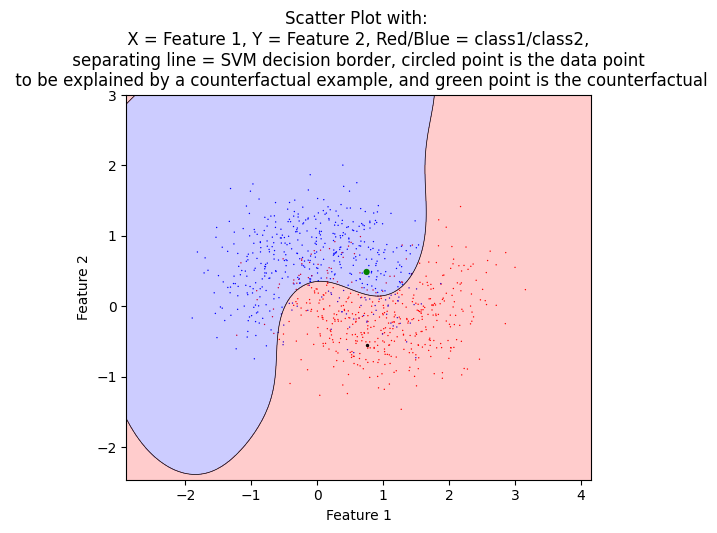

In [237]:
print("Data point we're studying: ", X_test_noise2[0])
e_noise2 = growingSpheresGen(clf_noise2, X_test_noise2[0], 0.1, 5)
e_opt_noise2 = growingSpheresFeatureSelec(clf_noise2, X_test_noise2[0], e_noise2)
print("Counterfactual point we got: ", e_opt_noise2)
plotResults_2Features_SVM(X_train_noise2, y_train_noise2, clf_noise2, X_test_noise2[0], y_test_noise2[0], e_opt_noise2)

**Nombre de points générés à chaque étape: 10**

Data point we're studying:  [ 0.75136837 -0.54480462]
Counterfactual point we got:  [0.75136837 0.31881109]


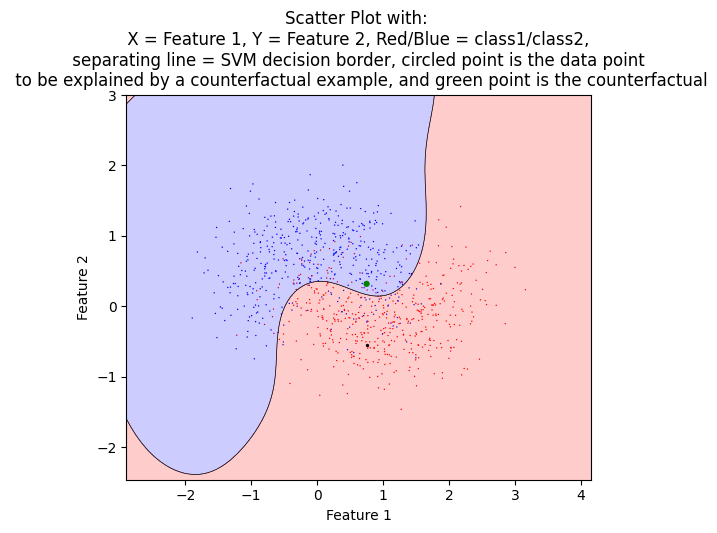

In [238]:
print("Data point we're studying: ", X_test_noise2[0])
e_noise2 = growingSpheresGen(clf_noise2, X_test_noise2[0], 0.1, 10)
e_opt_noise2 = growingSpheresFeatureSelec(clf_noise2, X_test_noise2[0], e_noise2)
print("Counterfactual point we got: ", e_opt_noise2)
plotResults_2Features_SVM(X_train_noise2, y_train_noise2, clf_noise2, X_test_noise2[0], y_test_noise2[0], e_opt_noise2)

**Nombre de points générés à chaque étape: 25**

Data point we're studying:  [ 0.75136837 -0.54480462]
Counterfactual point we got:  [0.75136837 0.18634828]


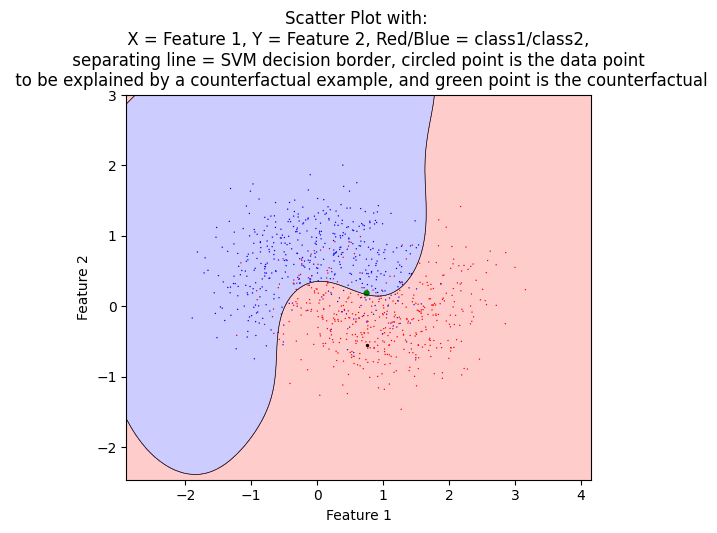

In [239]:
print("Data point we're studying: ", X_test_noise2[0])
e_noise2 = growingSpheresGen(clf_noise2, X_test_noise2[0], 0.1, 25)
e_opt_noise2 = growingSpheresFeatureSelec(clf_noise2, X_test_noise2[0], e_noise2)
print("Counterfactual point we got: ", e_opt_noise2)
plotResults_2Features_SVM(X_train_noise2, y_train_noise2, clf_noise2, X_test_noise2[0], y_test_noise2[0], e_opt_noise2)

**Interprétation:**<br>Plus on ajoute des points générés dans la sphere à chaque étape, plus l'éstimation de l'exemple contrefactuel se raproche de la frontiere de décision du classifieur puisque la génération de plus de points aléatoires augmente la chance d'obtenir l'exemple contrefactuel le plus optimal possible.


    Faute de temps, la partie suivante n'est pas finalisée, désolé!

**Variation du classifieur: Random Forest Classifier**

In [240]:
# Variation du classifieur

RFC = RandomForestClassifier(max_depth=2, random_state=0)
RFC.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [241]:
print("Data point we're studying: ", X_test[0])
e_RFC = growingSpheresGen(RFC, X_test[0], 0.1, 10)
e_opt_RFC = growingSpheresFeatureSelec(RFC, X_test[0], e_RFC)
print("Counterfactual point we got: ", e_opt_RFC)

Data point we're studying:  [ 0.49818367 -0.3649742 ]
Counterfactual point we got:  [-0.23437717  0.03011733]


**6. Expérimentations sur données classiques**

As those dataset have more features than the previous 2 feature dataset we can select two features from them.

In [242]:
# different datasets

X_brest, y_brest = load_breast_cancer(return_X_y=True)
X_wine, y_wine = load_wine(return_X_y=True)

NameError: name 'load_breast_cancer' is not defined

In [ ]:
# select two features so that we can visualize
X_brest_selected = X_brest[:, [0,1]]
X_wine_selected = X_wine[:, [0,6]]

# force binary classification for wine
y_wine = (y_wine == 0).astype(int)

In [ ]:
# divide in train and test
X_brest_train, X_brest_test, y_brest_train, y_brest_test = train_test_split(X_brest_selected, y_brest, test_size=0.1, random_state=42)
X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine_selected, y_wine, test_size=0.1, random_state=42)

In [ ]:
clf_brest = svm.SVC()
clf_wine = svm.SVC()

In [ ]:
clf_brest.fit(X_brest_train,y_brest_train)
clf_wine.fit(X_wine_train,y_wine_train)

In [ ]:
e_brest = growingSpheresGen(clf_brest, X_brest_test[0], 0.1, 10)
e_brest_opt = growingSpheresFeatureSelec(clf_brest, X_brest_test[0], e_brest)

In [ ]:
e_wine = growingSpheresGen(clf_wine, X_wine_test[0], 0.1, 10)
e_wine_opt = growingSpheresFeatureSelec(clf_wine, X_wine_test[0], e_wine)

In [ ]:
plotResults_2Features(X_brest_train, y_brest_train, clf_brest, X_brest_test[0], y_brest_test[0], e_brest_opt)

In [ ]:
plotResults_2Features(X_wine_train, y_wine_train, clf_wine,
                      X_wine_test[0], y_wine_test[0], e_wine_opt)